


Sample Text: This is an example sentence to test the tokenizer.
Token IDs: [757, 298, 355, 1768, 9371, 288, 3555, 263, 12410, 12202, 16]
Tokens: ['This', 'Ġis', 'Ġan', 'Ġexample', 'Ġsentence', 'Ġto', 'Ġtest', 'Ġthe', 'Ġtoken', 'izer', '.']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/cc-filer/home/sabulikailik/.local/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1 - Training: 100%|██████████| 12500/12500 [01:41<00:00, 122.60it/s]


Epoch 1 - Training Loss: 0.6914


Epoch 1 - Evaluating: 100%|██████████| 12500/12500 [00:34<00:00, 358.74it/s]


Epoch 1 - Evaluation Loss: 0.6847
Epoch 1 - Accuracy: 0.5590, Precision: 0.6050, Recall: 0.3402, F1 Score: 0.4355


Epoch 2 - Training: 100%|██████████| 12500/12500 [01:41<00:00, 122.69it/s]


Epoch 2 - Training Loss: 0.6730


Epoch 2 - Evaluating: 100%|██████████| 12500/12500 [00:34<00:00, 359.06it/s]


Epoch 2 - Evaluation Loss: 0.6577
Epoch 2 - Accuracy: 0.6123, Precision: 0.6724, Recall: 0.4380, F1 Score: 0.5305


Epoch 3 - Training: 100%|██████████| 12500/12500 [01:41<00:00, 122.64it/s]


Epoch 3 - Training Loss: 0.6200


Epoch 3 - Evaluating: 100%|██████████| 12500/12500 [00:34<00:00, 359.31it/s]


Epoch 3 - Evaluation Loss: 0.6141
Epoch 3 - Accuracy: 0.6582, Precision: 0.7590, Recall: 0.4638, F1 Score: 0.5757


Epoch 4 - Training: 100%|██████████| 12500/12500 [01:41<00:00, 122.60it/s]


Epoch 4 - Training Loss: 0.5378


Epoch 4 - Evaluating: 100%|██████████| 12500/12500 [00:34<00:00, 359.44it/s]


Epoch 4 - Evaluation Loss: 0.5185
Epoch 4 - Accuracy: 0.7460, Precision: 0.7491, Recall: 0.7397, F1 Score: 0.7444


Epoch 5 - Training: 100%|██████████| 12500/12500 [01:41<00:00, 122.87it/s]


Epoch 5 - Training Loss: 0.4666


Epoch 5 - Evaluating: 100%|██████████| 12500/12500 [00:34<00:00, 360.38it/s]


Epoch 5 - Evaluation Loss: 0.4944
Epoch 5 - Accuracy: 0.7661, Precision: 0.8212, Recall: 0.6804, F1 Score: 0.7442

Final Evaluation Metrics Across All Epochs:
Average Accuracy: 0.6683
Average Precision: 0.7213
Average Recall: 0.5324
Average F1 Score: 0.6061


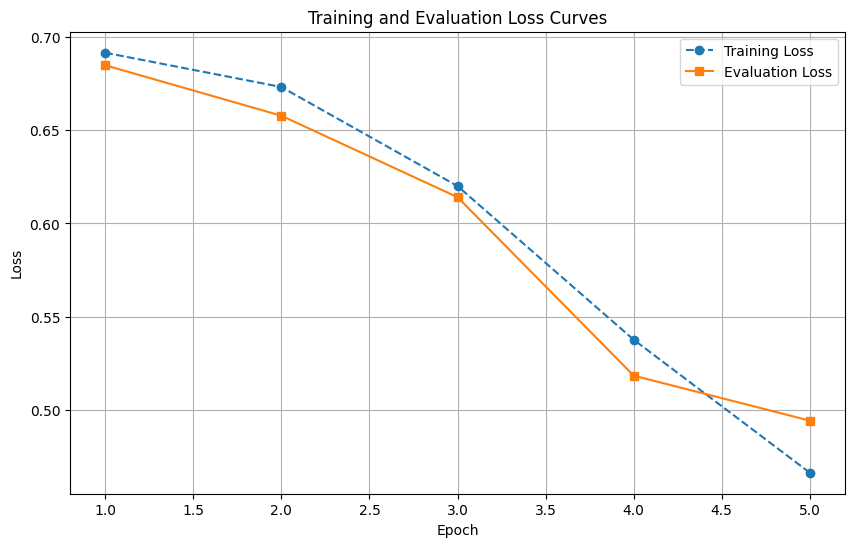

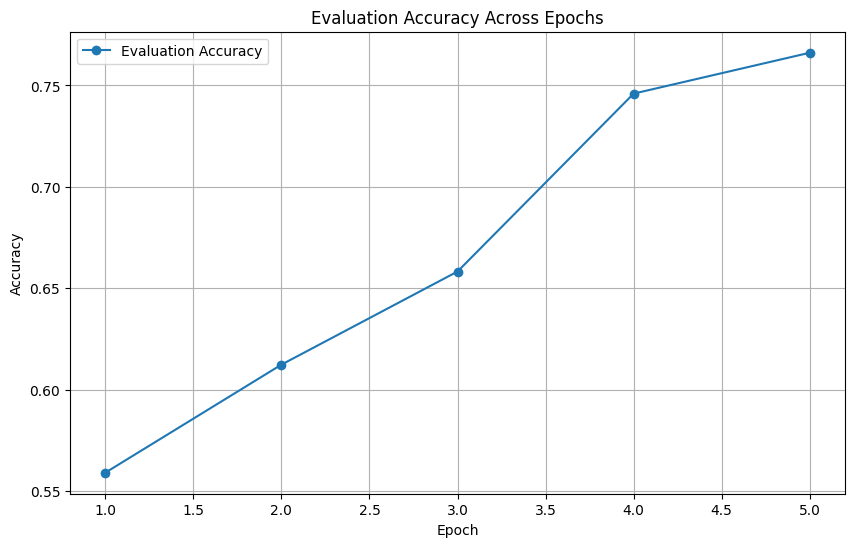

In [2]:
import os
import torch
from tokenizers import ByteLevelBPETokenizer
from transformers import BertForSequenceClassification, BertConfig, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import AutoModelForSequenceClassification


def load_model(model_name, num_labels=2):
    """
    Loads a pre-trained model for sequence classification.
    """
    if model_name == "bert-tiny":
        model_name = "prajjwal1/bert-tiny"  # Correct model identifier on Hugging Face
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Step 1: Load a classification dataset (IMDb)
dataset = load_dataset("imdb")
train_texts = dataset["train"]["text"] 
train_labels = dataset["train"]["label"]  
test_texts = dataset["test"]["text"]      
test_labels = dataset["test"]["label"]     

# Step 2: Train a BPE tokenizer and add special tokens
os.makedirs("bpe_tokenizer", exist_ok=True)
tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["<pad>", "<cls>", "<sep>"])
tokenizer.save_model("bpe_tokenizer")

# Reload tokenizer
tokenizer = ByteLevelBPETokenizer("bpe_tokenizer/vocab.json", "bpe_tokenizer/merges.txt")

# Ensure the pad token is in the vocabulary
if "<pad>" not in tokenizer.get_vocab():
    tokenizer.add_special_tokens(["<pad>"])
pad_token_id = tokenizer.token_to_id("<pad>")
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")

# Sample text to test the tokenizer
sample_text = "This is an example sentence to test the tokenizer."

# Encode the sample text
encoded = tokenizer.encode(sample_text)

# Display the tokenized output
print("Sample Text:", sample_text)
print("Token IDs:", encoded.ids)
print("Tokens:", encoded.tokens)


# Step 3: Prepare a custom dataset class
# Step 3: Prepare a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        tokenized = self.tokenizer.encode(text)

        # Ensure the sequence length (including special tokens) is within max_length
        max_token_length = self.max_length - 2  # Reserve space for <cls> and <sep>
        token_ids = tokenized.ids[:max_token_length]

        # Add special tokens
        token_ids = [cls_token_id] + token_ids + [sep_token_id]

        # Convert to PyTorch tensors
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)


# Step 4: Collate function for DataLoader
def collate_fn(batch):
    texts, labels = zip(*batch)
    # Use pad_token_id as padding_value
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=pad_token_id)
    return padded_texts, torch.tensor(labels, dtype=torch.long)

# Prepare train and test datasets
train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# Step 5: Load BERT and adjust embedding layer
# config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
# model = BertForSequenceClassification(config)
model_name = "prajjwal1/bert-tiny"
model = load_model(model_name, num_labels=2)


# Adjust embedding layer to match new vocabulary size
vocab_size = tokenizer.get_vocab_size()
model.resize_token_embeddings(vocab_size)

# Step 6: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-6, weight_decay=2e-4)

# Initialize a list to store the loss values
train_losses = []

# Training loop
# Initialize lists to store evaluation losses and metrics
eval_losses = []
eval_accuracies = []
# Initialize lists to store evaluation metrics across all epochs
final_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

for epoch in range(5):
    # Training Phase
    model.train()
    total_loss = 0
    for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(input_ids=texts, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    # Compute and store average training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

    # Evaluation Phase
    model.eval()
    eval_loss = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} - Evaluating"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(input_ids=texts, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

            # Predictions and true labels
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average evaluation loss
    avg_eval_loss = eval_loss / len(test_loader)
    eval_losses.append(avg_eval_loss)
    print(f"Epoch {epoch + 1} - Evaluation Loss: {avg_eval_loss:.4f}")

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_predictions, average='binary', pos_label=1)
    f1 = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    
    eval_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store metrics for final summary
    final_metrics["accuracy"].append(accuracy)
    final_metrics["precision"].append(precision)
    final_metrics["recall"].append(recall)
    final_metrics["f1"].append(f1)

# Print final aggregated metrics
print("\nFinal Evaluation Metrics Across All Epochs:")
print(f"Average Accuracy: {sum(final_metrics['accuracy']) / len(final_metrics['accuracy']):.4f}")
print(f"Average Precision: {sum(final_metrics['precision']) / len(final_metrics['precision']):.4f}")
print(f"Average Recall: {sum(final_metrics['recall']) / len(final_metrics['recall']):.4f}")
print(f"Average F1 Score: {sum(final_metrics['f1']) / len(final_metrics['f1']):.4f}")

# Plot training and evaluation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss', linestyle='--')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, marker='s', label='Evaluation Loss', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.grid()
plt.show()

# Plot evaluation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, marker='o', label='Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy Across Epochs')
plt.legend()
plt.grid()
plt.show()


